# Movie Revenue and Profit Prediction 

This notebook works through regression models related to predicting the box office revenue of movies released between 1995 and June 2018.  The related GitHub for this project is here: https://github.com/georgetown-analytics/Box-Office.  

The raw data sources were cleaned, wrangled, and had some pre-processing performed on them in separate python codes stored here: https://github.com/georgetown-analytics/Box-Office/tree/master/codes.  

The final dataset is stored in a SQLite database here: https://github.com/georgetown-analytics/Box-Office/tree/master/database.

This notebook is for the modeling stage of the project and includes regression models.

Author: Rebecca George.  Team Box Office: George Brooks, Rebecca George, Lance Liu

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import pandas.io.sql as pd_sql
import sqlite3 as sql
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import (BaggingClassifier, ExtraTreesClassifier, 
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import (LinearRegression, LogisticRegressionCV, 
    LogisticRegression, SGDClassifier, Ridge, Lasso, ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.svm import LinearSVC, NuSVC, SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.neural_network import MLPClassifier

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from yellowbrick.classifier import ClassificationReport, ROCAUC
from yellowbrick.features import FeatureImportances

from imblearn.over_sampling import SMOTE
import os
from sklearn.tree import export_graphviz
import pydot

%matplotlib inline

Get path to folder storing the SQLite database

In [5]:
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
path = two_up + '\database\movies.db'

In [6]:
con = sql.connect(path) 

data = pd_sql.read_sql('select * from finalMovies_20180814', con, index_col='index')


# Regression Models

This section will look at whether we can predict the actual revenue of movies using regression modeling techniques.  

In [7]:
#Limit dataset to those with filled in Revenue, Budget, and Length columns.  Based on what I've seen, this helps to
#get rid of remaining duplicates in dataset.  Also helps to narrow down dataset to test profitability, where we
#need both revenue and budget filled in. Here, we could experiment with movies with revenue greater than $500,000, if 
#we choose to avoid smaller movies. Can also avoid largest revenues above $1 billion, if necessary.
movies = data[(data['Revenue_Real']>0)&(data['Budget_Real']>0)&(data['Length']>0)&(data['Revenue_Actor_Real']>0)&
             (data['Revenue_Director_Real']>0)&(data['Revenue_Writer_Real']>0) & (data['Year']>=2008)]

#Put zero where null
movies['Revenue_Actor_Real']=movies['Revenue_Actor_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Director_Real']=movies['Revenue_Director_Real'].apply(lambda x: 0 if pd.isnull(x) else x)
movies['Revenue_Writer_Real']=movies['Revenue_Writer_Real'].apply(lambda x: 0 if pd.isnull(x) else x)

#Could experiment with logged values of revenue and budget
movies['Revenue_Real_Log']=np.log(movies['Revenue_Real'])
movies['Budget_Real_Log']=np.log(movies['Budget_Real'])
movies['Revenue_Actor_Real_Log']=np.log(movies['Revenue_Actor_Real'])
movies['Revenue_Director_Real_Log']=np.log(movies['Revenue_Director_Real'])
movies['Revenue_Writer_Real_Log']=np.log(movies['Revenue_Writer_Real'])

#Create a feature called 'constant' to use in regression model.
movies['constant'] =1

### First, let's just include all features we have in the linear regression.

Want to see what could be significant. For now, I am logging any revenue or budget feature that appears as a dependent or independent variable.  These features are very skewed, and prices can't be negative and tend to follow a log-normal distribution anyway. However, this requires limiting our dataset to those where the independent variables for historical cast/crew revenues needs to be greater than 0.

In [8]:
#Set X, y
X = movies[['constant', "Budget_Real_Log", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log',
'Nominated_Major','Nominated_Minor', 'Won_Major', 'Won_Minor']]

y = movies['Revenue_Real_Log']

In [9]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     53.36
Date:                Sun, 02 Sep 2018   Prob (F-statistic):          3.34e-232
Time:                        14:53:35   Log-Likelihood:                -1986.5
No. Observations:                1169   AIC:                             4057.
Df Residuals:                    1127   BIC:                             4270.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
constant              

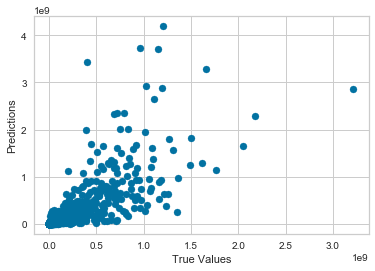

In [10]:
%matplotlib inline
plt.scatter(np.exp(y), np.exp(results.fittedvalues))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

### Let's try removing variables that are either not significant, may contribute to dummy variable trap, or may not be available prior to a movie's release. The featureSelectionMoviesData notebook stored in the same folder as this notebook also has some insight into the most correlated variables to a movie's revenue.

We'll remove some of the season variables, some of the genre variables, some of the company variables, and some of the rated variables. We'll also remove the awards features because, although they are important, they likely will only be available during or after a movie's run in theaters.

In [33]:
X_restricted = movies[['constant', "Budget_Real_Log", 'Fall',
'Rating_RT', 'Rating_IMDB', 'isCollection','Length',
'Genre_Drama', 'Genre_Thriller_Horror',
'Rated_G_PG', 'Rated_PG-13', 'Rated_Other',
'Comp_Disney','Comp_Fox', 'Comp_Lionsgate',
 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros',   
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log'
]]
y = movies["Revenue_Real_Log"]

In [34]:
model_restricted = sm.OLS(y, X_restricted)
results = model_restricted.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       Revenue_Real_Log   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     98.38
Date:                Sun, 02 Sep 2018   Prob (F-statistic):          6.69e-239
Time:                        14:56:50   Log-Likelihood:                -2015.1
No. Observations:                1169   AIC:                             4074.
Df Residuals:                    1147   BIC:                             4186.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
constant              

### Using the restricted set of features, let's create a train and test set of data to see how the regression performs.

We'll use sklearn instead of statsmodel here. We will print out the training and testing set's r_squared and mean absolute error in dollars.

In [35]:
# Split up the data with the 'train test split' method.
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_restricted, y, test_size = 0.2, random_state=seed)

0.5897971853381692
 Training set MAE: 98342770.66745582 dollars 
 Training set r_squared: 0.6522837214257879 
 Testing set MAE: 107356940.25648159 dollars 
 Testing set r_squared: 0.5897971853381692 



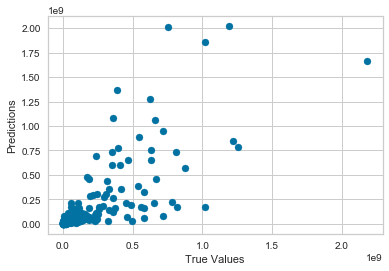

In [36]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(lm.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, lm.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(lm.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, lm.predict(X_test)), '\n',)

plt.scatter(np.exp(y_test), np.exp(lm.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


### Now, try using Ridge, Lasso, and ElasticNet regressions to see if those models can restrict variables for us.

I am keeping all original features except those related to Awards, and I am also removing the constant I created. 

In [37]:
X = movies[["Budget_Real_Log", "Holiday", "Summer", "Spring", "Fall", "Winter",
'Rating_RT', 'Rating_IMDB', 'Rating_Metacritic','isCollection','Length',
'Genre_Drama', 'Genre_Comedy', 'Genre_Action_Adventure', 'Genre_Thriller_Horror',
 'Genre_Romance', 'Genre_Crime_Mystery', 'Genre_Animation', 'Genre_Scifi',
 'Genre_Documentary', 'Genre_Other',
'Rated_G_PG', 'Rated_PG-13', 'Rated_R', 'Rated_Other',
'Comp_Disney','Comp_DreamWorks', 'Comp_Fox', 'Comp_Lionsgate',
 'Comp_MGM', 'Comp_Miramax', 'Comp_Paramount', 'Comp_Sony',
 'Comp_Universal', 'Comp_WarnerBros', 'Comp_Other',  
'Revenue_Actor_Real_Log','Revenue_Director_Real_Log', 'Revenue_Writer_Real_Log']]
#'constant', 
y = movies['Revenue_Real_Log']
seed=3
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2, random_state=seed)

0.601578872630715
 Training set MAE: 92530113.55642968 dollars 
 Training set r_squared: 0.6514503859299698 
 Testing set MAE: 103832651.12791786 dollars 
 Testing set r_squared: 0.601578872630715 



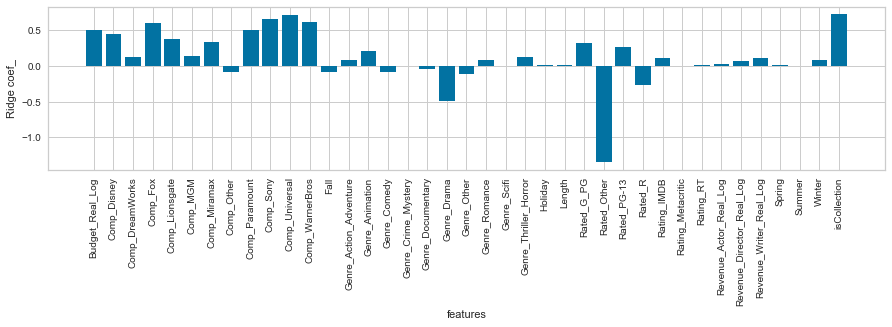

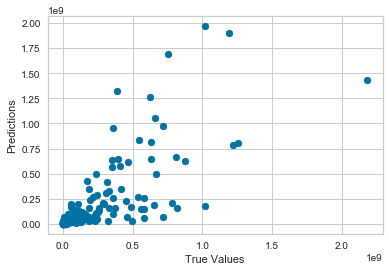

In [38]:
#Ridge Regression
ridgereg = RidgeCV(fit_intercept=True, normalize=True) #alpha=.5,
ridgereg.fit(X_train, y_train)
print(ridgereg.score(X_test, y_test))
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(ridgereg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, ridgereg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(ridgereg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, ridgereg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, ridgereg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Ridge coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(ridgereg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

0.566682983916205
 Training set MAE: 83380274.46191168 dollars 
 Training set r_squared: 0.6390399875592081 
 Testing set MAE: 96839735.02859879 dollars 
 Testing set r_squared: 0.566682983916205 



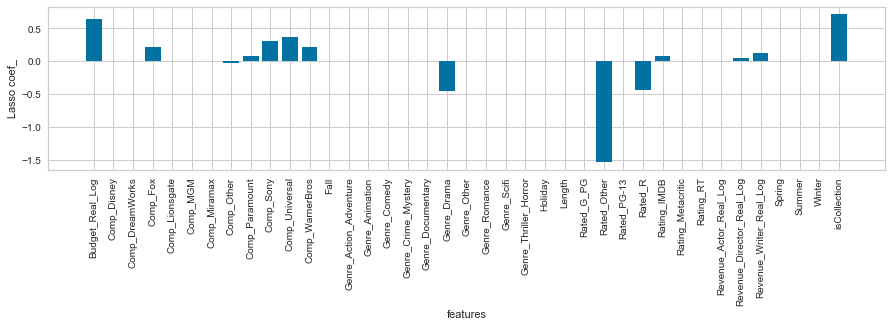

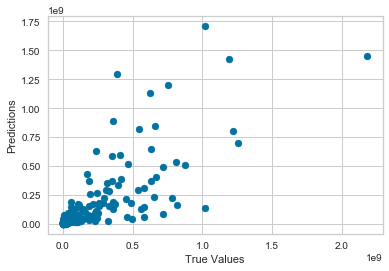

In [39]:
#Lasso Regression
lassoreg = LassoCV(fit_intercept=True, normalize=True) #alpha=0.001,
lassoreg.fit(X_train, y_train)
print(lassoreg.score(X_test, y_test))
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(lassoreg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, lassoreg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(lassoreg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, lassoreg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, lassoreg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Lasso coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(lassoreg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

0.5959435433942961
 Training set MAE: 84132894.87869318 dollars 
 Training set r_squared: 0.6381953318951232 
 Testing set MAE: 96769749.39139524 dollars 
 Testing set r_squared: 0.5959435433942961 



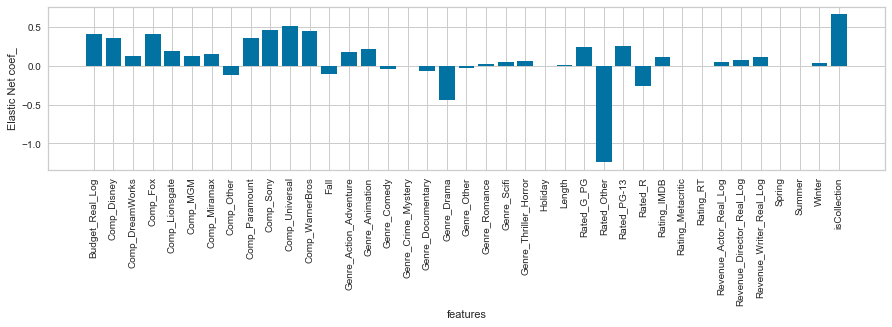

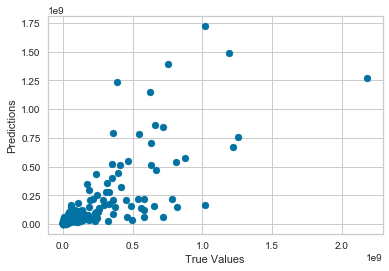

In [41]:
#Elastic Net Regression
elasticreg = ElasticNetCV(fit_intercept=True, normalize=True) #alpha=.001,l1_ratio=.80, 
elasticreg.fit(X_train, y_train)
print(elasticreg.score(X_test, y_test))
print(" Training set MAE:", mean_absolute_error(np.exp(y_train), np.exp(elasticreg.predict(X_train))), "dollars", '\n',
      "Training set r_squared:", r2_score(y_train, elasticreg.predict(X_train)), '\n',
      "Testing set MAE:", mean_absolute_error(np.exp(y_test), np.exp(elasticreg.predict(X_test))), "dollars", '\n',
      "Testing set r_squared:", r2_score(y_test, elasticreg.predict(X_test)), '\n',)
plt.figure(figsize=(15,3))
plt.bar(X.columns, elasticreg.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Elastic Net coef_")
plt.show()

plt.scatter(np.exp(y_test), np.exp(elasticreg.predict(X_test)))
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


### Ridge, Lasso, and ElasticNet regressions seem to do better.  Further test with k-fold cross validation

I am keeping all original features except those related to Awards, and I am also removing the constant I created. 

In [42]:
models = [
    RidgeCV(fit_intercept=True, normalize=True),
    LassoCV(fit_intercept=True, normalize=True),
    ElasticNetCV(fit_intercept=True, normalize=True)]

In [43]:
for mdl in models:

    name = mdl.__class__.__name__
    #y_int = y.astype(int)
    scoring_list = ['r2']#, 'neg_mean_absolute_error']
    scores = cross_validate(mdl, X, y, cv=10, scoring=scoring_list, return_train_score=False)  
    
    print(name, 
          '\n', "\tR2:",scores['test_r2'].mean(),
          #'\n', "\tMean Absolute Error:", scores['test_neg_mean_absolute_error'].mean(),
          '\n' 
         )    

RidgeCV 
 	R2: 0.6144835842481708 

LassoCV 
 	R2: 0.6129031189593205 

ElasticNetCV 
 	R2: 0.6149107814104561 




### These three models are relatively the same.  They seem to be worse than the regression for the entire 1995-2018 time frame.  So we won't be using these in our data product.  Code below is still available to store models.

Store a model in GitHub folder called "final_model"

In [46]:
##Code to store lasso model in GitHub.  Commented out to prevent writing over current model.
#two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
#filename = two_up + r'\final_models\lassoPost2008_20180901.pkl'
#joblib.dump(lassoreg, filename)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)
0.566682983916205


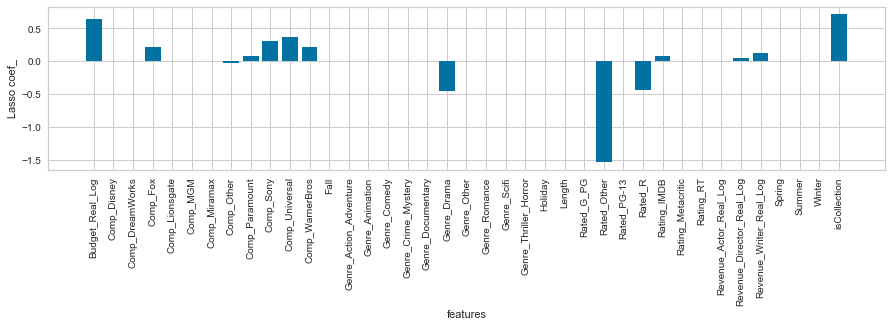

In [45]:
#Code to double check stored Lasso model is the same as what was created above.

two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
filename = two_up + r'\final_models\lassoPost2008_20180901.pkl'
lasso = joblib.load(filename)
print(lasso)
lasso.fit(X_train, y_train)
print(lasso.score(X_test, y_test))

plt.figure(figsize=(15,3))
plt.bar(X_train.columns, lasso.coef_)
plt.xticks(rotation=90)
plt.xlabel("features")
plt.ylabel("Lasso coef_")
plt.show()
